In [11]:
from pybaseball import statcast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = statcast(start_dt="2025-04-01", end_dt="2025-04-15") 

This is a large query, it may take a moment to complete


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.06it/s]


In [3]:
pitches = data.pitch_type.value_counts()[:8].index.to_list()
features = ["release_speed", "release_spin_rate", "pfx_x", "pfx_z","plate_x","plate_z","release_pos_x","release_pos_z","release_extension"]
data2 = data.dropna(subset = features)
data2 = data2[data2.pitch_type.isin(pitches)]

# Features
We will be using all of the same features as in our decision tree along with the following new ones:
* plate_x - horizontal position of the ball when it crosses home plate from the catcher's perspective.
* plate_z - vertical position of the ball when it crosses home plate from the catcher's perspective.
* release_pos_x - -   horizontal release position of the ball measured in feet from the catcher's perspective.
* release_pos_z - vertical release position of the ball measured in feet from the catcher's perspective.
* release_extension - release extension of pitch in feet as tracked by Statcast.

Two preliminary visualizations are below:

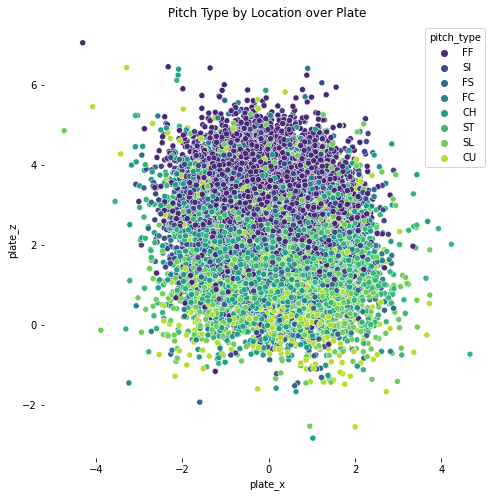

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.despine(fig, left=True, bottom=True)
sns.scatterplot(x="plate_x", y="plate_z",
                hue="pitch_type", 
                palette='viridis', 
                data=data2, ax=ax)
ax.set_title("Pitch Type by Location over Plate")
plt.show()

In [5]:
# Converting release_extension to float
data2.release_extension = data2.release_extension.astype(float)

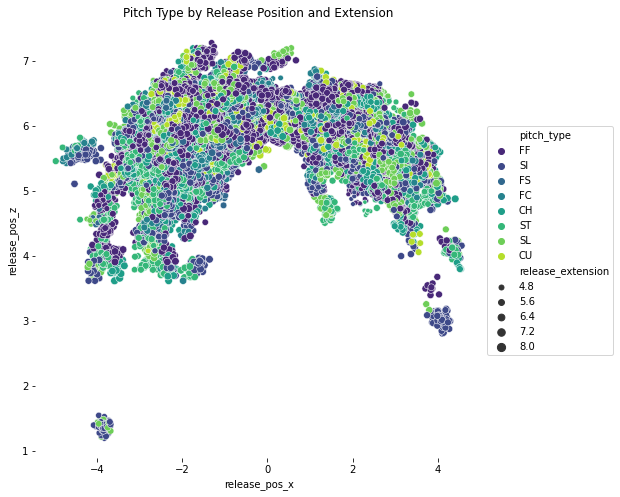

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.despine(fig, left=True, bottom=True)
sns.scatterplot(x="release_pos_x", y="release_pos_z",
                    size="release_extension",
                hue="pitch_type", 
                palette='viridis', 
                data=data2, ax=ax)
ax.set_title("Pitch Type by Release Position and Extension")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()


These two plots are used to highlighy different factors when can consider to help us classify pitches, especially based on locations in space at different points in times.

# Random Forest
We will have 1000 trees, each with a maximum depth of 20. They will all use the entropy criterion. We will use all processors when training the model. Again behind the scene three main proc

* **Bootstrapping**: training each tree on different subsets of pitches (with replacement meaning pitches can be used multiple times)
* **Random Feature Selection**: training trees on different sets of features (one tree may only be trained on release_pos_x and release_speed, while another might be trained on release_speed, release_spin_rate, pfx_z, and plate_x).
* **Voting**:  From our 1000 trees, the most commonly predicted pitch is what our tree will classify the input as.

The purpose of this is to prevent over fitting by creating more models that work on different parts and features of the data.

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


X = data2[features]
y = data2['pitch_type']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)


model = RandomForestClassifier(max_depth = 20, n_estimators = 1000,
                                    n_jobs = -1, random_state=16, criterion = "entropy")
model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=1000,
                       n_jobs=-1, random_state=16)

In [38]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

          CH       0.91      0.96      0.94      1151
          CU       0.96      0.92      0.94       677
          FC       0.89      0.80      0.84       884
          FF       0.96      0.98      0.97      3685
          FS       0.94      0.79      0.86       443
          SI       0.94      0.94      0.94      1627
          SL       0.88      0.92      0.90      1626
          ST       0.91      0.92      0.91       844

    accuracy                           0.93     10937
   macro avg       0.92      0.90      0.91     10937
weighted avg       0.93      0.93      0.93     10937



Our Random Forrest has an accuracy of 93% (better than our Decision Tree that had an accuraucy of 78%). We also have much higher precisions and recalls. However our model is lagging for recall of specility pitches FC (cutters) and FS (splitters) -- only correctly identifying around 80% of these pitches, compared above 90% of the time for the rest of the pitches. 

In [9]:
for name, score in zip(features, model.feature_importances_):
    print(f"{name}:{score:.4f}")

release_speed:0.2493
release_spin_rate:0.1464
pfx_x:0.1790
pfx_z:0.2243
plate_x:0.0171
plate_z:0.0281
release_pos_x:0.0771
release_pos_z:0.0507
release_extension:0.0279


Another interesting note is that we can see what features the random forest viewed as most important. Namely, release_speed, pf_z, pf_x, and release_spin_rate acount for around 80% of the model. This means our new features are not quite as important but could still be useful for edge cases.

# Experiment with Ensemble

What if we could use ensemble techniques and real world geometric properties of pitches to classify them with a voting technique. This would allow us to have our pannel of voters be not only decision trees, but different models with different areas of expertise.

Imagine if we had the following three models:
* Decision Tree that classifies pitches based off of there speed, spin, and trajectory (our decision tree from the decision tree section),
* KNN for pitches based on where on there plate_x and plate_z
* KNN for pitches based on there release_pos_x, release_pos_z,release_extension

Thus we have different models that specelize on classifying different parts of the pitch and we will take there votes. The models also make sense based on the categories of what they are classifying. For factors relating to the ball's position in space, we use KNN. For factors relating to movement factors we use a decision tree


For our voting classifier, we will use soft voting. Rather than each classifier getting one vote, it votes based on its confidence of each class. Then the highest percent wins. Percentages are calculated as follows:
* Decision Tree: If our pitch is classifed by the tree as FF, at our leaf node the percentage of pitches at the node that are FF
* KNN: If our pitch is classified by the KNN as an FF, the percentage of neighbors that are FF

In [16]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier


# Define feature subsets
X1 = X_train[["release_speed", "release_spin_rate", "pfx_x", "pfx_z",]]  # Features for model 1
X2 = X_train[["plate_x","plate_z",]]  # Features for model 2
X3 = X_train[["release_pos_x","release_pos_z","release_extension"]]  # Features for model 3

# Train models separately
clf1 = DecisionTreeClassifier(max_depth=20, criterion = "entropy", random_state=16).fit(X1, y_train)
clf2 = KNeighborsClassifier(n_neighbors = 7).fit(X2, y_train)
clf3 = KNeighborsClassifier(n_neighbors = 7).fit(X3, y_train)

# Create VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('dt', clf1), ('knn_plate', clf2), ('knn_release', clf3)], voting='soft')

# Use only shared feature set for final predictions
voting_clf.fit(X, y)

VotingClassifier(estimators=[('dt',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=20,
                                                     random_state=16)),
                             ('knn_plate', KNeighborsClassifier(n_neighbors=7)),
                             ('knn_release',
                              KNeighborsClassifier(n_neighbors=7))],
                 voting='soft')

In [17]:
y_pred = voting_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

          CH       0.95      0.98      0.97      1127
          CU       0.99      0.97      0.98       679
          FC       0.97      0.87      0.92       891
          FF       0.97      1.00      0.98      3705
          FS       0.97      0.92      0.95       418
          SI       0.99      0.95      0.97      1663
          SL       0.93      0.97      0.95      1603
          ST       0.98      0.95      0.97       851

    accuracy                           0.97     10937
   macro avg       0.97      0.95      0.96     10937
weighted avg       0.97      0.97      0.97     10937



### Ensemble Results
This is interesting. Even though our Random Forest ranked our three groups of factors as such:
* 80% pitch movement
* 4% plate_position
* 16% pitch release position

Using these seperate groups of factors determined by real world intuition and using models that reflect that reflect that intuition seems to work well. We have our highest yet accuruacy at 97% and even our specialty pitches have recalls at least 87%. All our precisions arae above 93%. This just highlights the power of ensemble methods.